## Import Necessary Packages

In [1]:
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import uniform_filter1d
import proplot as pplt
pplt.rc.update({'font.size':12})
import warnings
warnings.filterwarnings('ignore')

## User-Defined Fields

In [2]:
path  = # '/directory/where/large/domain/files/are/located/'
cases = ['nz_32','nz_64','nz_128']

## Calculate Aggregation Metrics

Calculate daily-mean vertical velocity at the pressure level closest to 500 hPa ($w_{500}$), then calculate subsidence fraction $SF$ as the fractional area of the domain where $w_{500}$ < 0. Calculate the daily-mean spatial variance of column frozen moist static energy $\langle h_f \rangle'$ as deviations from the horizontal domain-mean. 

In [4]:
sf    = []
hfvar = []
for i,case in enumerate(cases):
    ## Calculate Subsidence Fraction
    pfiles = np.sort(glob.glob(path+case+'/OUT_3D/p/*.nc'))[0]
    wfiles = np.sort(glob.glob(path+case+'/OUT_3D/W/*.nc'))
    p = xr.open_dataset(pfiles).p
    i500 = np.argmin(np.abs(p.values-500))
    w500 = xr.open_mfdataset(wfiles).isel(z=i500).W
    w500daily = w500.groupby(np.floor(w500.time)).mean('time')
    sf.append(np.nanmean(w500daily<0,axis=(1,2)))
    del p
    del i500
    del w500
    del w500daily
    ## Calculate Spatial Variance of Column FMSE
    hffiles = np.sort(glob.glob(path+case+'/OUT_3D/FMSE/*.nc'))
    hf = xr.open_mfdataset(hffiles).fmse_vint
    hfdaily = hf.groupby(np.floor(hf.time)).mean('time')
    hfvar.append(hfdaily.var(dim=('x','y'))/1e15)     
    del hf
    del hfdaily

## Plot Fig. 5

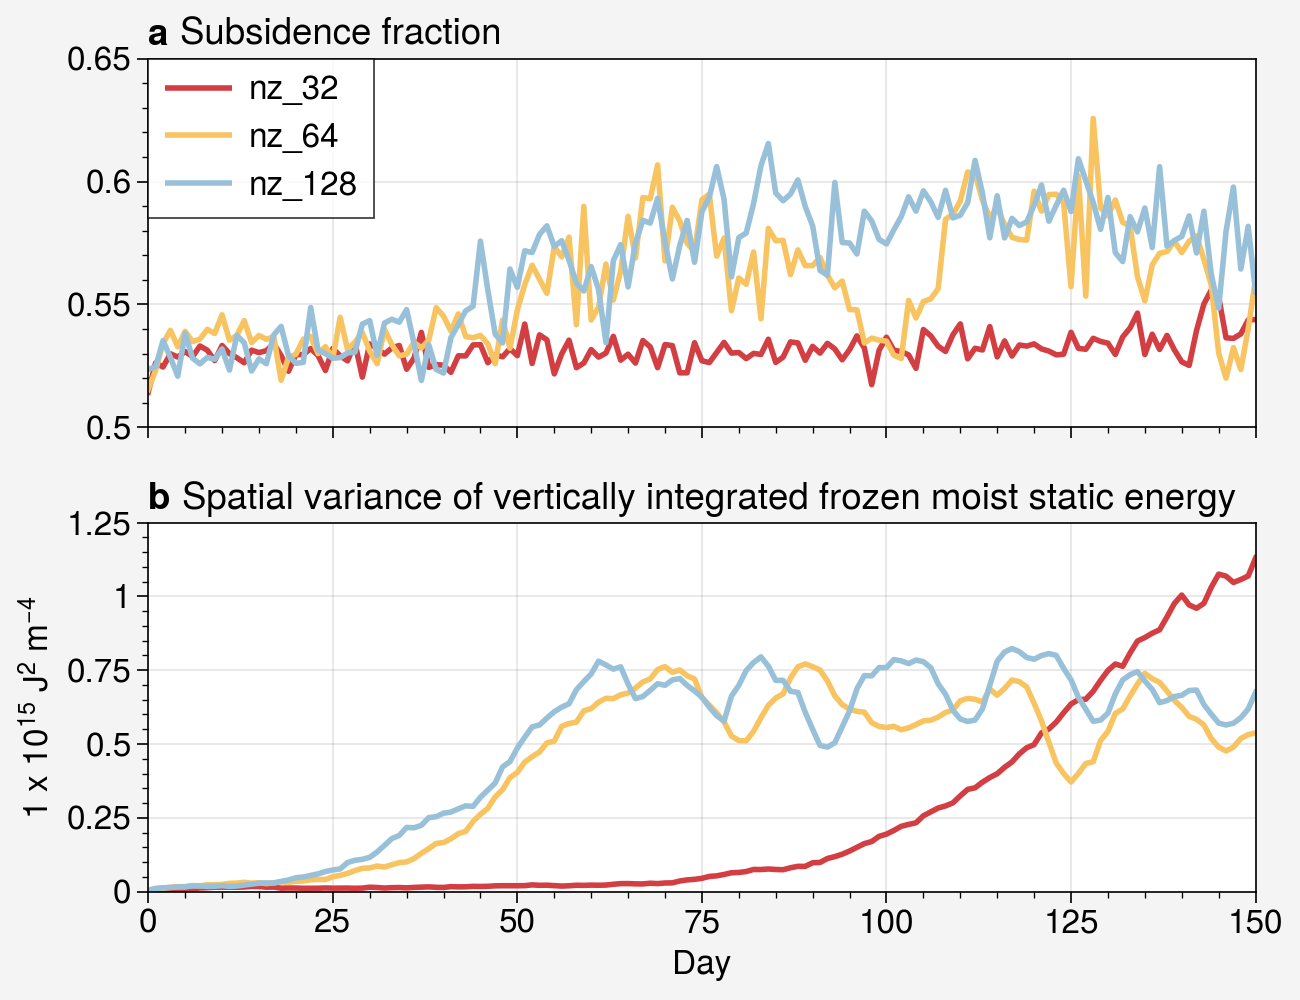

In [6]:
cmap=np.asarray([[211,62,67,255],[248,196,98,255],[152,193,217,255]])/255; linewidth=2
fig,axs = pplt.subplots(nrows=2,ncols=1,width=6.5,height=5,sharex=True,sharey=False)
axs.format(xlabel='Day',xlim=(0,150),xticks=25,ylabel='',abc='a',abcloc='l',titleloc='l')
for i,case in enumerate(cases):
    axs[0].plot(sf[i],color=cmap[i],label=case,linewidth=linewidth)
    axs[0].format(title='Subsidence fraction',ylim=(0.5,0.65))
    axs[0].legend(loc='ul',ncols=1)
    axs[1].plot(hfvar[i],color=cmap[i],linewidth=linewidth)
    axs[1].format(title='Spatial variance of vertically integrated frozen moist static energy',
                  ylabel='1 x 10$^{15}$ J$^{2}$ m$^{-4}$',ylim=(0,1.25))